In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
plt.style.use('ggplot')
pd.set_option('display.max_rows', 500)
# Bigger plots.
plt.rcParams["figure.figsize"] = (18,10)

In [2]:
df = pd.read_csv("powerproduction.csv")
df

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [3]:
#Remove unreasonable power values
zeroVals = df[(df["speed"] > 10) & (df["power"] == 0)].index
df.drop(zeroVals, inplace=True)

In [4]:
x = np.array(df["speed"])
y = np.array(df["power"])

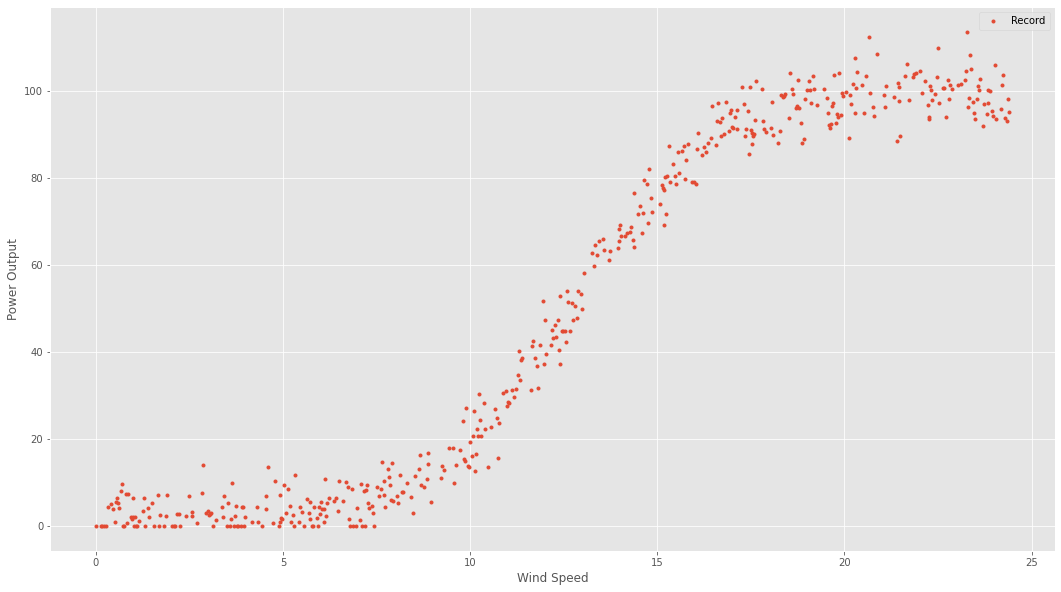

In [5]:
#Plotting the full dataset
plt.plot(x, y,'.', label="Record")
# Add axis labels and a legend.
plt.xlabel('Wind Speed')
plt.ylabel('Power Output')
plt.legend()


In [6]:
#using numpy polyfit to find the best line.
linmodel = np.poly1d(np.polyfit(x, y, 1))

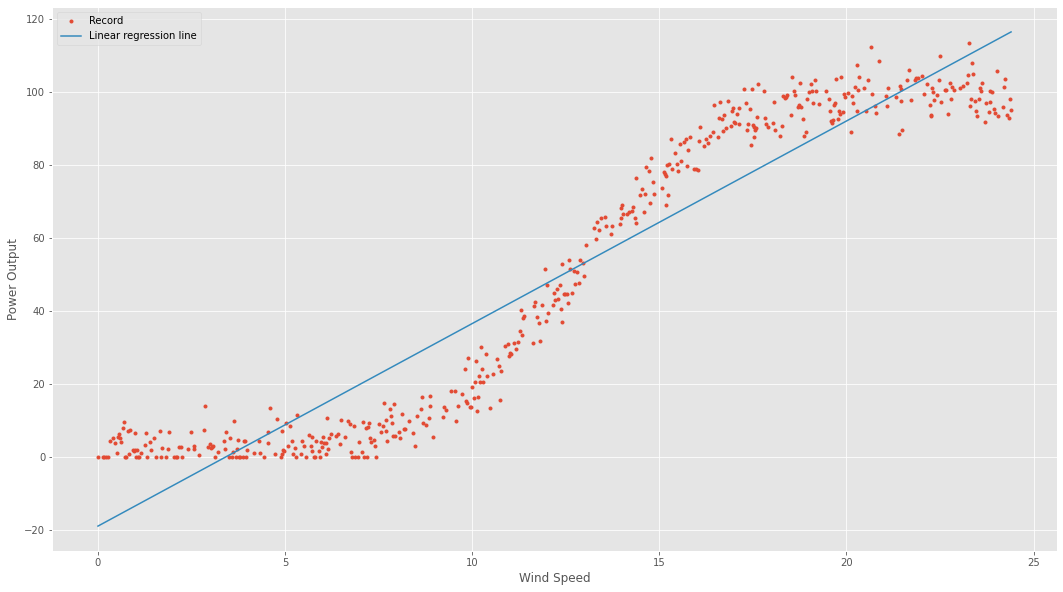

In [7]:
#Plotting the best fit line on the data.
plt.plot(x, y,'.', label="Record")
plt.plot(x, linmodel(x), label="Linear regression line")
# Add axis labels and a legend.
plt.xlabel('Wind Speed')
plt.ylabel('Power Output')
plt.legend()

#### Calculating Cost

In [8]:
# Calculate the cost of the lines above for the data above.
c = linmodel[0]
m = linmodel[1]
cost = lambda m,c: np.sum([(y[i] - m * x[i] - c)**2 for i in range(x.size)])


print("Cost with m = %5.2f and c = %5.2f: %8.2f" % (m, c, cost(m, c)))

Cost with m =  5.55 and c = -18.87: 80977.03


In [9]:
#calculating r-squared value, 0 = no relation, 1 = 100% related
print(r2_score(y, linmodel(x)))

0.9025487607456801


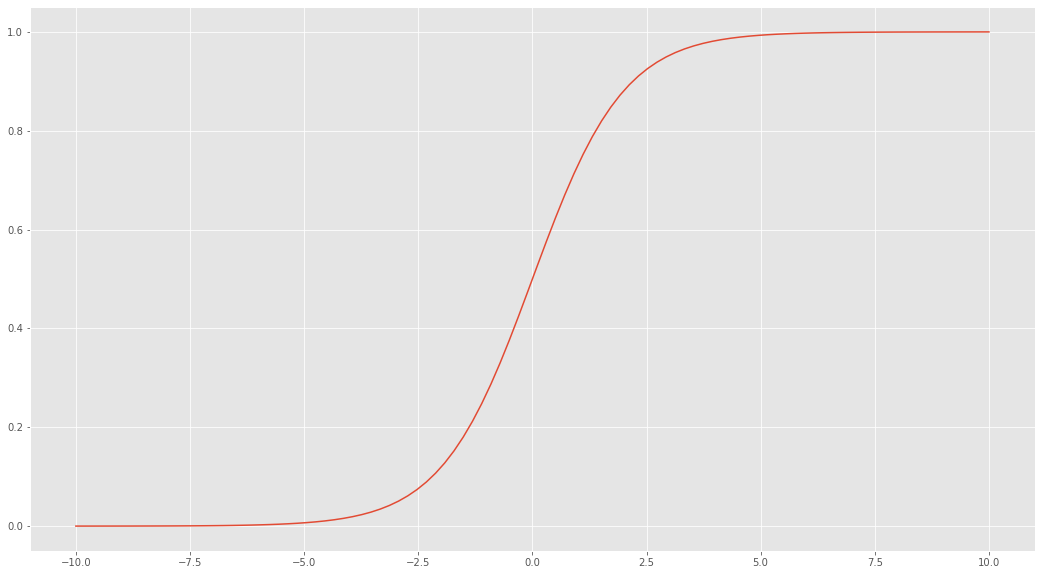

In [10]:
#sigmoid function
c = np.linspace(-10, 10, 100) 
z = 1/(1 + np.exp(-c)) 
plt.plot(c,z)

<br>

#### Polynomial Regression
***

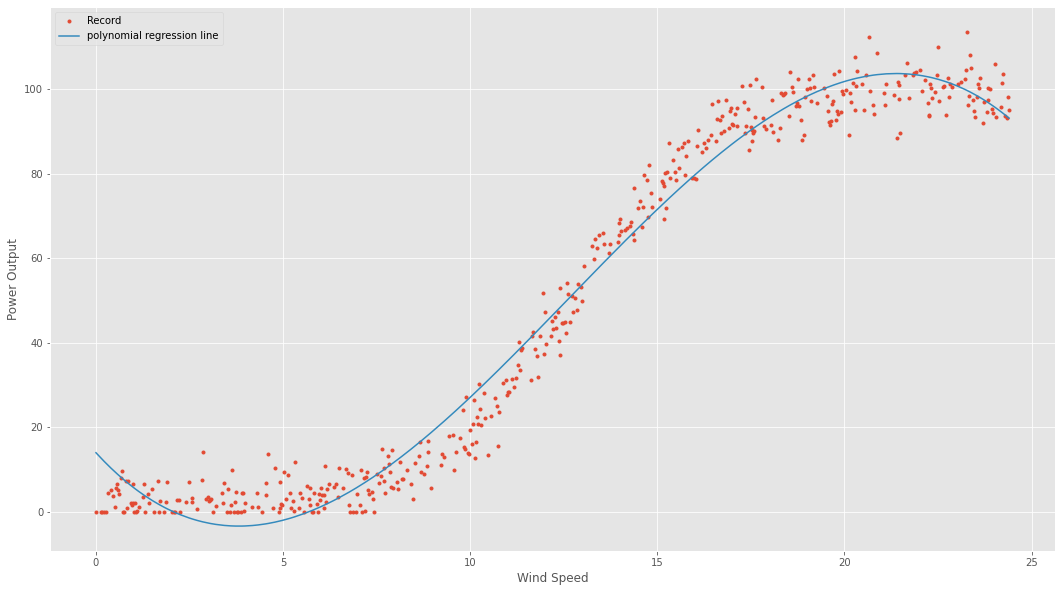

In [11]:
#Creating and plotting line of polynomial regression
polymodel = np.poly1d(np.polyfit(x, y, 3))
plt.plot(x, y,'.', label="Record")
plt.plot(x, polymodel(x), label="polynomial regression line")
plt.xlabel('Wind Speed')
plt.ylabel('Power Output')
plt.legend()

In [12]:
#calculating r-squared value, 0 = no relation, 1 = 100% related
print(r2_score(y, polymodel(x)))

0.978871374241535


In [13]:
#Picking a random record from the dataset
df.loc[256]

speed    12.788
power    50.658
Name: 256, dtype: float64

In [14]:
#Prediction of power at speed of 12.788
power = polymodel(12.788)
print(power)

51.88072390243623


<br>
***

100.60654089102331 744.0047757183004 0.5208494317358437
[  0.13504147   0.15399512   0.17560434   0.20023981   0.22832352
   0.26033578   0.29682306   0.33840696   0.38579422   0.43978803
   0.50130074   0.5713681    0.65116514   0.74202394   0.84545328
   0.9631604    1.09707491   1.249375     1.42251571   1.61925954
   1.84270886   2.09634001   2.38403836   2.71013374   3.07943494
   3.49726186   3.96947334   4.50248812   5.10329564   5.77945302
   6.5390634    7.39073033   8.34348231   9.40666102  10.58976685
  11.90225579  13.35328309  14.95139133  16.70414397  18.61771052
  20.69641495  22.94226661  25.35449965  27.9291544   30.65873872
  33.53200969  36.53391349  39.64571368  42.84532498  46.10785223
  49.40631384  52.71250915  55.99797252  59.23494655  62.39730442
  65.46135758  68.40649866  71.21564782  73.87549138  76.37652085
  78.71289609  80.88216691  82.88489292  84.72420116  86.40531794
  87.93510492  89.32162245  90.57373577  91.7007731   92.71223928
  93.61758421  94.42

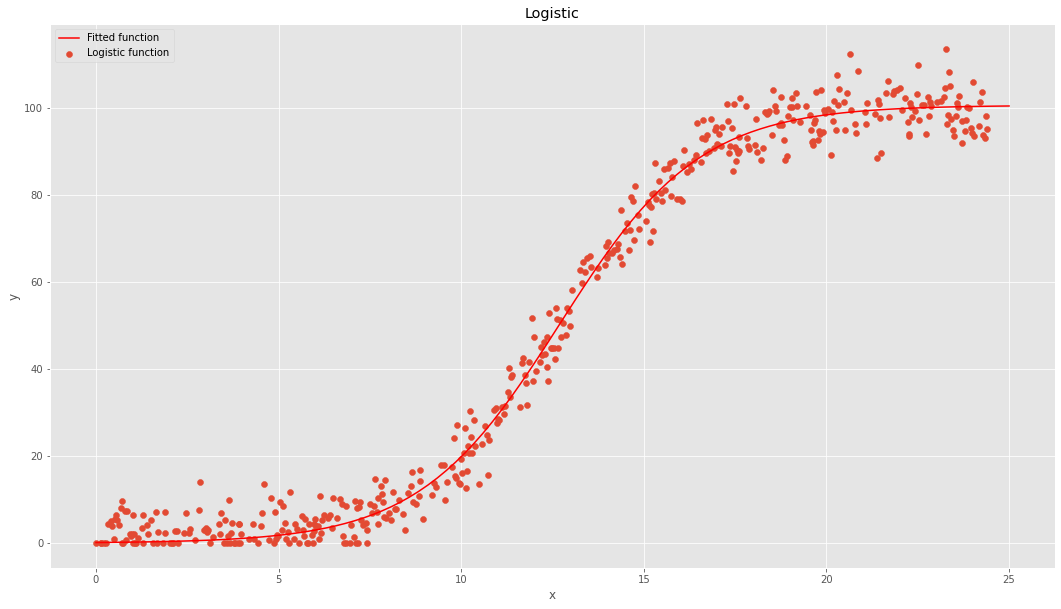

In [39]:


def logifunc(x,l,c,k):
    return l / (1 + c*np.exp(-k*x))

popt, pcov = curve_fit(logifunc, x, y, p0=[100,1,1])
print(*popt)

x_data = np.linspace(0,25,num=100)
print(logifunc(x_data, *popt))

plt.scatter(x,y,label='Logistic function')
plt.plot(x_data, logifunc(x_data, *popt), 'r-',label='Fitted function')

plt.title("Logistic")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
